Plot the score box plot and histogram plot

In [1]:
import sys
sys.path.append("/home/wanxinli/OTTEHR/")

from ast import literal_eval
from common import *
from math import floor
from mimic_common import *
from multiprocess import Pool
import numpy as np
import os
import pandas as pd
import random
import scipy.stats as ss
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import scipy.stats as ss
from statistics import median
import time


/home/wanxinli/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
output_dir = os.path.join(os.path.expanduser("~"), f"OTTEHR/outputs/mimic")
print(f"Will save outputs to {output_dir}")

Will save outputs to /home/wanxinli/OTTEHR/outputs/mimic


In [37]:
# Construct label_code datafame 

diagnose_path = "/home/wanxinli/OTTEHR/mimic_exp/mimiciii/D_ICD_DIAGNOSES.csv"
diagnose_df = pd.read_csv(diagnose_path, header=0, index_col=0)
diagnose_df

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
ICD code,,,,
011.66,174,01166,TB pneumonia-oth test,"Tuberculous pneumonia [any form], tubercle bac..."
011.70,175,01170,TB pneumothorax-unspec,"Tuberculous pneumothorax, unspecified"
011.71,176,01171,TB pneumothorax-no exam,"Tuberculous pneumothorax, bacteriological or h..."
011.72,177,01172,TB pneumothorx-exam unkn,"Tuberculous pneumothorax, bacteriological or h..."
011.73,178,01173,TB pneumothorax-micro dx,"Tuberculous pneumothorax, tubercle bacilli fou..."
...,...,...,...,...
V73.99,14432,V7399,Scrn unspcf viral dis,Special screening examination for unspecified ...
V74.0,14433,V740,Screening for cholera,Screening examination for cholera
V74.1,14434,V741,Screening-pulmonary TB,Screening examination for pulmonary tuberculosis


In [38]:
label_code_df = pd.DataFrame()
label_codes = get_label_codes()
label_code_df['ICD code'] = label_codes
print(label_codes)

short_titles = []
long_titles = []
for code in label_codes:
    if code not in list(diagnose_df.index):
        short_titles.append(np.nan)
        long_titles.append(np.nan)
    else:
        short_titles.append(diagnose_df.loc[code]['SHORT_TITLE'])
        long_titles.append(diagnose_df.loc[code]['LONG_TITLE'])

label_code_df["short title"] = short_titles
label_code_df["long title"] = long_titles
label_code_df = label_code_df.set_index('ICD code')
label_code_df

['V45.11', '041.4', '770.89', '294.10', '276.52', '560.1', '707.03', 'V43.64', '493.20', '244.9', 'V49.86', '530.81', '998.11', '788.20', 'V29.0', 'V30.01', '401.1', '112.0', 'V45.82', '331.4', '570', '428.32', '512.1', '345.90', 'V44.1', '518.5', '790.7', 'V10.05', '765.27', '571.5', '280.9', '300.4', '780.09', '348.4', 'V43.3', '276.3', '518.82', '362.01', '693.0', '294.8', 'V17.3', '197.0', '453.8', 'V45.01', '518.84', '584.5', '486', 'V09.0', '397.0', '070.54', '041.11', '765.26', '458.29', '276.7', '765.28', '769', '507.0', '779.89', '428.21', '443.9', '578.9', '780.57', '274.9', '997.4', '276.5', '998.59', '787.91', '401.9', '562.10', '287.5', '572.3', '593.9', 'E879.0', '715.90', '585.3', '428.0', '997.31', '305.1', 'V45.81', 'V15.82', '571.2', 'E888.9', '599.0', 'V66.7', '070.70', '348.30', '536.3', '311', '410.71', '416.8', '770.81', '765.19', '431', '276.6', '272.0', '276.51', '583.81', 'V12.54', 'V42.2', '038.9', '300.00', 'V12.51', '428.23', 'V15.81', 'E879.8', '779.81', '2

,short title,long title
ICD code,,
V45.11,Renal dialysis status,Renal dialysis status
041.4,NaN,NaN
770.89,Resp prob after brth NEC,Other respiratory problems after birth
294.10,Dementia w/o behav dist,Dementia in conditions classified elsewhere wi...
276.52,Hypovolemia,Hypovolemia
...,...,...
286.6,Defibrination syndrome,Defibrination syndrome
518.81,Acute respiratry failure,Acute respiratory failure
724.2,Lumbago,Lumbago


In [39]:
trans_codes = []
untrans_codes = []
undec_codes = []
for label_code in label_codes:
    score_path = os.path.join(output_dir, f"exp3_{label_code}_OT_score.csv")
    df = pd.read_csv(score_path, header=0, index_col=0)
    label_code_df.at[label_code, 'div_score'] = median(list(df['transfer_score']))
    
label_code_path = os.path.join(output_dir, "selected_codes.csv")
label_code_df.to_csv(label_code_path, header=True, index=True)


In [40]:
label_code_df = pd.read_csv(label_code_path, header=0, index_col=0)
label_code_df

,short title,long title,div_score
ICD code,,,
V45.11,Renal dialysis status,Renal dialysis status,42.179796
041.4,NaN,NaN,144.272391
770.89,Resp prob after brth NEC,Other respiratory problems after birth,32.385155
294.10,Dementia w/o behav dist,Dementia in conditions classified elsewhere wi...,124.889946
276.52,Hypovolemia,Hypovolemia,122.863476
...,...,...,...
286.6,Defibrination syndrome,Defibrination syndrome,97.866379
518.81,Acute respiratry failure,Acute respiratory failure,128.075337
724.2,Lumbago,Lumbago,140.677681


In [41]:
label_code_df = label_code_df.sort_values(by=['div_score'])
label_code_df

,short title,long title,div_score
ICD code,,,
V29.0,NB obsrv suspct infect,Observation for suspected infectious condition,25.472641
V30.00,Single lb in-hosp w/o cs,"Single liveborn, born in hospital, delivered w...",26.850411
770.6,NB transitory tachypnea,Transitory tachypnea of newborn,30.715341
V05.3,Need prphyl vc vrl hepat,Need for prophylactic vaccination and inoculat...,30.929815
770.89,Resp prob after brth NEC,Other respiratory problems after birth,32.385155
...,...,...,...
769,Respiratory distress syn,Respiratory distress syndrome in newborn,205.257223
410.41,"AMI inferior wall, init",Acute myocardial infarction of other inferior ...,216.618280
413.9,Angina pectoris NEC/NOS,Other and unspecified angina pectoris,223.537312


The performance of transferabilty (transferability score) is irrelevant of male to female ratio. 

In [42]:
def decide_ICD_chapter(code):
    """ 
    Decide ICD code chapter based on 
    https://en.wikipedia.org/wiki/List_of_ICD-9_codes_E_and_V_codes:_external_causes_of_injury_and_supplemental_classification 

    Rules:
    Chapter	Block	Title
    1	001–139	Infectious and Parasitic Diseases
    2	140–239	Neoplasms
    3	240–279	Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders
    4	280–289	Diseases of the Blood and Blood-forming Organs
    5	290–319	Mental Disorders
    6	320–389	Diseases of the Nervous System and Sense Organs
    7	390–459	Diseases of the Circulatory System
    8	460–519	Diseases of the Respiratory System
    9	520–579	Diseases of the Digestive System
    10	580–629	Diseases of the Genitourinary System
    11	630–679	Complications of Pregnancy, Childbirth, and the Puerperium
    12	680–709	Diseases of the Skin and Subcutaneous Tissue
    13	710–739	Diseases of the Musculoskeletal System and Connective Tissue
    14	740–759	Congenital Anomalies
    15	760–779	Certain Conditions originating in the Perinatal Period
    16	780–799	Symptoms, Signs and Ill-defined Conditions
    17	800–999	Injury and Poisoning
    18  E800–E999   Supplementary Classification of External Causes of Injury and Poisoning
    19  V01–V82	Supplementary Classification of Factors influencing Health Status and Contact with Health Services
    20  M8000–M9970	Morphology of Neoplasms
    """

    block = code.split(".")[0]
    if block.startswith("E"):
        return 18, "Supplementary Classification of External Causes of Injury and Poisoning"
    if block.startswith("V"):
        return 19, "Supplementary Classification of Factors influencing Health Status and Contact with Health Services"
    if block.startswith("M"):
        return 20, "Morphology of Neoplasms"
    
    # otherwise, numerical code
    block_segs = [1, 140, 240, 280, 290, 320, 390, 460, 520, 580, 630, 680, 710, 740, 760, 780, 800, 1000]
    titles = ["Infectious and Parasitic Diseases", 
              "Neoplasms", 
              "Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders", \
        "Diseases of the Blood and Blood-forming Organs", 
        "Mental Disorders", 
        "Diseases of the Nervous System and Sense Organs", \
        "Diseases of the Circulatory System", 
        "Diseases of the Respiratory System", 
        "Diseases of the Digestive System", \
        "Diseases of the Genitourinary System", 
        "Complications of Pregnancy, Childbirth, and the Puerperium", 
        "Diseases of the Skin and Subcutaneous Tissue",\
        "Diseases of the Musculoskeletal System and Connective Tissue", 
        "Congenital Anomalies", 
        "Certain Conditions originating in the Perinatal Period", \
        "Symptoms, Signs and Ill-defined Conditions", 
        "Injury and Poisoning" ]
    block = int(block)
    for chapter_index in range(len(block_segs)):
        left = block_segs[chapter_index]
        right = block_segs[chapter_index+1]
        if left <= block and block < right:
            return chapter_index+1, titles[chapter_index]


In [43]:
chapters = []
for index, row in label_code_df.iterrows():
    chapters.append(decide_ICD_chapter(index)[0])

In [44]:

# chapter: 1-20
# div_score_bin: 1-10
chapter_num = 20

div_score_bin_width = 5
div_score_max = 250
div_score_bin_num = int(div_score_max/div_score_bin_width)


def determine_div_score_bin(div_score):
    return floor(div_score/div_score_bin_width)+1

heatmap_dict = {}
for chapter_index in range(1, chapter_num+1):
    heatmap_dict[chapter_index] = {}
    for div_index in range(1, div_score_bin_num+1):
        heatmap_dict[chapter_index][div_index] = 0
# print(heatmap_dict)

for index, row in label_code_df.iterrows():
    chapter_index = decide_ICD_chapter(index)[0]
    div_index = determine_div_score_bin(row['div_score'])
    if div_index > div_score_bin_num:
        continue
    heatmap_dict[chapter_index][div_index] += 1
print("heatmap chapter 14 is:", heatmap_dict[14])

# normalize count to be rate, and compute the max rate bin
max_bin_ids = []
for chapter_index, chapter_item in heatmap_dict.items():
    # print(list(chapter_item.values))
    total_count = sum(chapter_item.values())
    # print(chapter_item.values())
    max_bin_id = np.argmax(list(chapter_item.values()))+1
    if total_count == 0:
        max_bin_ids.append(0)
        continue
    max_bin_ids.append(max_bin_id)
    for div_index in chapter_item:
        heatmap_dict[chapter_index][div_index] /= total_count

chapter_ranks = ss.rankdata(max_bin_ids, method='ordinal')
print(chapter_ranks)

# print(heatmap_dict)

heatmap_vec = []
for chapter_index, chapter_item in heatmap_dict.items():
    for div_index, count in chapter_item.items():
        heatmap_vec.append([chapter_ranks[chapter_index-1], div_index, count])

labels = ["Infectious and Parasitic Diseases", 
               "Neoplasms", 
               "Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders", \
                "Diseases of the Blood and Blood-forming Organs", 
                "Mental Disorders", 
                "Diseases of the Nervous System and Sense Organs", \
                "Diseases of the Circulatory System", 
                "Diseases of the Respiratory System", 
                "Diseases of the Digestive System", \
                "Diseases of the Genitourinary System", 
                "Complications of Pregnancy, Childbirth, and the Puerperium", 
                "Diseases of the Skin and Subcutaneous Tissue",\
                "Diseases of the Musculoskeletal System and Connective Tissue", 
                "Congenital Anomalies", 
                "Certain Conditions originating in the Perinatal Period", \
                "Symptoms, Signs and Ill-defined Conditions", 
                "Injury and Poisoning",
                "Supplementary External Causes of Injury and Poisoning",
                "Supplementary Factors influencing Health Status",
                "Morphology of Neoplasms"]
yticklabels = [""]*len(chapter_ranks)
for i in range(len(labels)):
    # print(chapter_ranks[i], labels[chapter_ranks[i]-1])
    yticklabels[chapter_ranks[i]-1] = labels[i]
print(yticklabels)
    
xticklabels = []
for bin_index in range(div_score_bin_num):
    xticklabels.append(f'{int(bin_index*div_score_bin_width)}-{int((bin_index+1)*div_score_bin_width)}')
heatmap_df = pd.DataFrame(heatmap_vec, columns=['chapter_rank', 'div_score_bin', 'density'])


heatmap chapter 14 is: {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 1, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0}
[18 20 12 13 15  4  5  8 16  9  1  6 10 14  3  7 19 17 11  2]
['Complications of Pregnancy, Childbirth, and the Puerperium', 'Morphology of Neoplasms', 'Certain Conditions originating in the Perinatal Period', 'Diseases of the Nervous System and Sense Organs', 'Diseases of the Circulatory System', 'Diseases of the Skin and Subcutaneous Tissue', 'Symptoms, Signs and Ill-defined Conditions', 'Diseases of the Respiratory System', 'Diseases of the Genitourinary System', 'Diseases of the Musculoskeletal System and Connective Tissue', 'Supplementary Factors influencing Health Status', 'Endocrine, Nutritional and Metabolic Diseases, a

/tmp/ipykernel_2290262/1232343922.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  sns.heatmap(heatmap_df.pivot('chapter_rank', 'div_score_bin', 'density'), xticklabels=xticklabels, yticklabels=yticklabels)


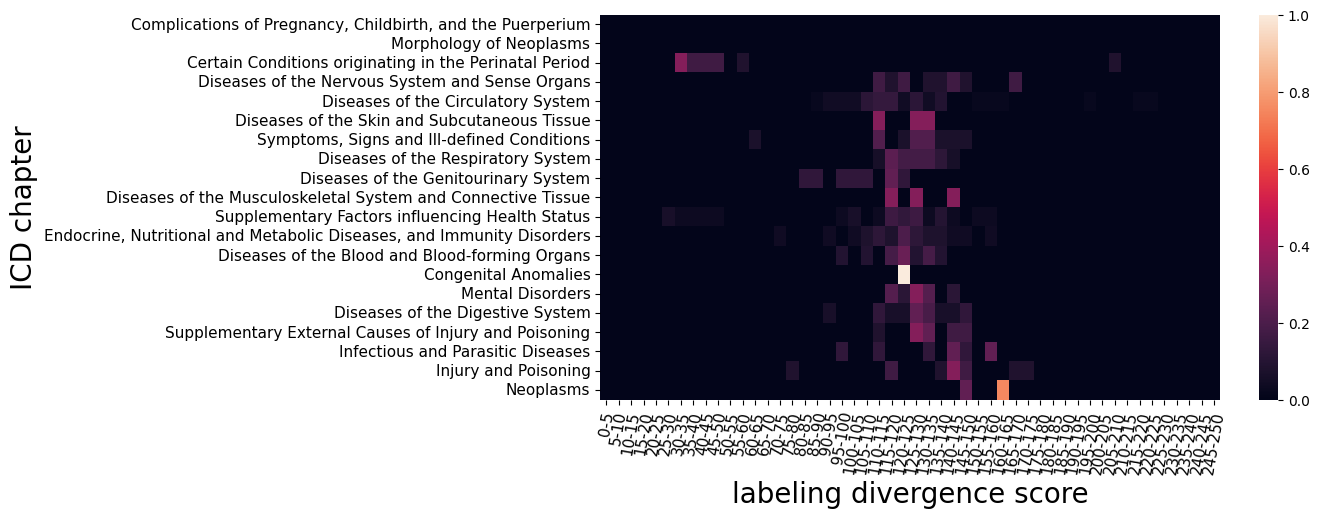

In [45]:
# sort heatmap_df by argmax of the label divergence score

plt.figure(figsize=[10,5])
fig_path = os.path.join(output_dir, "exp3_heatmap.pdf")
sns.heatmap(heatmap_df.pivot('chapter_rank', 'div_score_bin', 'density'), xticklabels=xticklabels, yticklabels=yticklabels)
plt.xlabel("labeling divergence score", fontsize=20)
plt.ylabel("ICD chapter", fontsize=20)
plt.xticks(fontsize=11, rotation=80)
plt.yticks(fontsize=11)
plt.savefig(fig_path, bbox_inches = 'tight')
plt.show()

In [46]:
""" 
Make the heatmap prettier
"""

# filter out "Diseases of the Circulatory System", 

# chapter: 1-20
# div_score_bin: 1-10
chapter_num = 20

div_score_bin_width = 5
div_score_max = 200
div_score_min = 25
div_score_bin_num = int((div_score_max-div_score_min)/div_score_bin_width)


def determine_div_score_bin(div_score):
    return floor((div_score-div_score_min)/div_score_bin_width)+1

heatmap_dict = {}
for chapter_index in range(1, chapter_num+1):
    if chapter_index == 14 or chapter_index == 11 or chapter_index == 20:
        continue
    heatmap_dict[chapter_index] = {}
    for div_index in range(1, div_score_bin_num+1):
        heatmap_dict[chapter_index][div_index] = 0

for index, row in label_code_df.iterrows():
    chapter_index = decide_ICD_chapter(index)[0]
    if chapter_index == 14 or chapter_index == 11 or chapter_index == 20:
        continue
    if row['div_score'] > div_score_max or row['div_score'] < div_score_min:
        continue
    div_index = determine_div_score_bin(row['div_score'])
    
    heatmap_dict[chapter_index][div_index] += 1
# print(heatmap_dict)

# normalize count to be rate, and compute the max rate bin
max_bin_ids = []
for chapter_index, chapter_item in heatmap_dict.items():
    # print(list(chapter_item.values))
    total_count = sum(chapter_item.values())
    # print(chapter_item.values())
    max_bin_id = np.argmax(list(chapter_item.values()))+1
    if total_count == 0:
        max_bin_ids.append(0)
        continue
    max_bin_ids.append(max_bin_id)
    for div_index in chapter_item:
        heatmap_dict[chapter_index][div_index] /= total_count
# print(heatmap_dict)

chapter_ranks = ss.rankdata(max_bin_ids, method='ordinal')
# print("chapter ranks is:", chapter_ranks)


heatmap_vec = []
for chapter_index, chapter_item in heatmap_dict.items():
    for div_index, count in chapter_item.items():
        if chapter_index < 11:
            heatmap_vec.append([chapter_ranks[chapter_index-1], div_index, count])
        elif chapter_index < 14:
            heatmap_vec.append([chapter_ranks[chapter_index-2], div_index, count])
        elif chapter_index < 20:
            heatmap_vec.append([chapter_ranks[chapter_index-3], div_index, count])
# print("heatmap_vec is:", heatmap_vec)

labels = ["1: Infectious and Parasitic Diseases", 
               "2: Neoplasms", 
               "3: Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders", \
                "4: Diseases of the Blood and Blood-forming Organs", \
                "5: Mental Disorders", \
                "6: Diseases of the Nervous System and Sense Organs", \
                "7: Diseases of the Circulatory System", 
                "8: Diseases of the Respiratory System", 
                "9: Diseases of the Digestive System", \
                "10: Diseases of the Genitourinary System", 
                # "Complications of Pregnancy, Childbirth, and the Puerperium", 
                "12: Diseases of the Skin and Subcutaneous Tissue",\
                "13: Diseases of the Musculoskeletal System and Connective Tissue", 
                # "Congenital Anomalies", 
                "15: Certain Conditions originating in the Perinatal Period", \
                "16: Symptoms, Signs and Ill-defined Conditions", 
                "17 Injury and Poisoning",
                "18: Supplementary External Causes of Injury and Poisoning",
                "19: Supplementary Factors influencing Health Status",
                # "Morphology of Neoplasms"
                ]

yticklabels = [""]*len(chapter_ranks)
# print(chapter_ranks)
for i in range(len(chapter_ranks)):
    yticklabels[chapter_ranks[i]-1] = labels[i]

# print(yticklabels)
    
xticklabels = []
for bin_index in range(div_score_bin_num):
    xticklabels.append(f'{int(bin_index*div_score_bin_width)+div_score_min}-{int((bin_index+1)*div_score_bin_width)+div_score_min}')
heatmap_df = pd.DataFrame(heatmap_vec, columns=['chapter', 'div_score_bin', 'density'])
heatmap_df[heatmap_df["chapter"]==3]
# print(yticklabels)



,chapter,div_score_bin,density
210,3,1,0.000000
211,3,2,0.000000
212,3,3,0.000000
213,3,4,0.000000
214,3,5,0.000000
215,3,6,0.000000
216,3,7,0.000000
217,3,8,0.000000
218,3,9,0.000000
219,3,10,0.000000


/tmp/ipykernel_2290262/274874789.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  ax = sns.heatmap(heatmap_df.pivot('chapter', 'div_score_bin', 'density'), xticklabels=xticklabels, yticklabels=yticklabels, cmap="Blues")


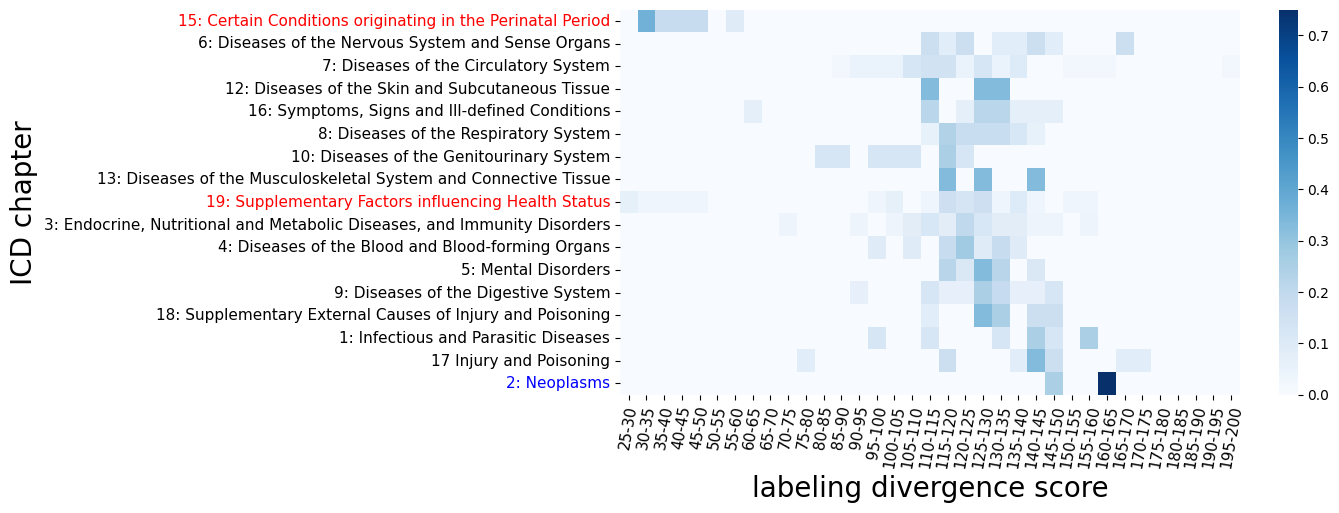

In [47]:
# sort heatmap_df by argmax of the label divergence score

plt.figure(figsize=[10,5])
fig_path = os.path.join(output_dir, "exp3_heatmap_subset.pdf")
ax = sns.heatmap(heatmap_df.pivot('chapter', 'div_score_bin', 'density'), xticklabels=xticklabels, yticklabels=yticklabels, cmap="Blues")
plt.xlabel("labeling divergence score", fontsize=20)
plt.ylabel("ICD chapter", fontsize=20)
plt.xticks(fontsize=11, rotation=80)
plt.yticks(fontsize=11)
for i, tick_label in enumerate(ax.axes.get_yticklabels()):
    # print(tick_label)
    if i == 0 or i == 8:
        tick_label.set_color("red")
    if i == 16:
        tick_label.set_color("blue")

# plt.savefig(fig_path, bbox_inches = 'tight')
plt.show()

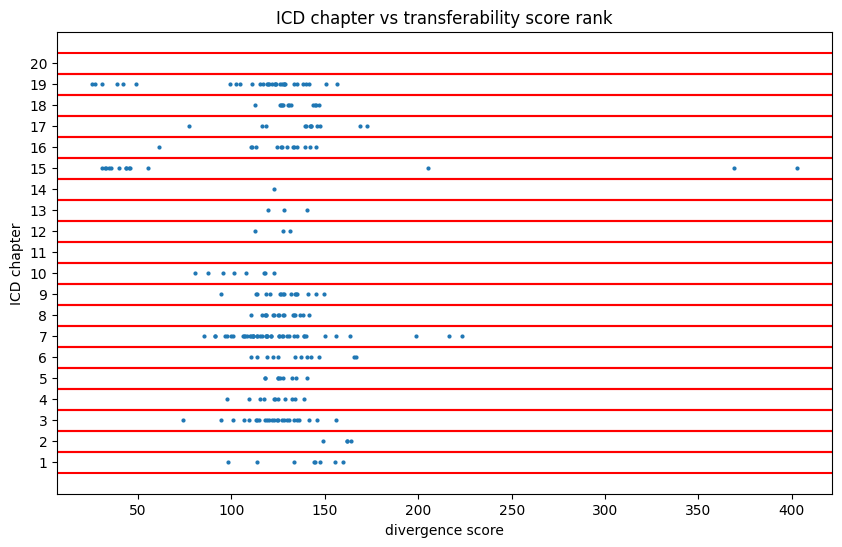

In [16]:
plt.figure(figsize=[10, 6])
plt.scatter(list(label_code_df['div_score']), chapters, s=4)
chapter_num = 20
plt.yticks(range(1, chapter_num+1))
for i in range(chapter_num):
    plt.axhline(i+0.5, color='red')
    plt.axhline(i+1.5, color='red')
plt.ylabel("ICD chapter")
plt.xlabel("divergence score")
plt.title("ICD chapter vs transferability score rank")
# plt.savefig("../../outputs/mimic/exp3_chapter.png")
plt.show()


In [28]:
# visualize performance (f1 score and recall) versus ICD chapter 

# determine the performance for each chapter 

def get_stats_chapter(eval_metric, diff=True):
    """ 
    Get the performance stats for all chapters

    :param str eval_metric: the evaluation metric, e.g., f1, recall
    :param bool diff: calculates the  different between transported target stat and target stat or not
    """

    # generate the stats for each code
    code_delta = {}
    for label_code in label_codes:
        score_path = os.path.join(output_dir, f"exp3_{label_code}_OT_score.csv")
        score_df = pd.read_csv(score_path, header=0, index_col=0)
        deltas = []
        for source_stat, target_stat, trans_target_stat in zip(score_df[f'source_{eval_metric}'], score_df[f'target_{eval_metric}'], score_df[f'trans_target_{eval_metric}']):
            if target_stat < source_stat:
                if diff:
                    deltas.append(trans_target_stat-target_stat)
                else:
                    deltas.append(trans_target_stat)
        code_delta[label_code] = deltas

    chapter_delta = {}
    # group codes into chapters
    for code, stats in code_delta.items():
        chapter_num, _ = decide_ICD_chapter(code)
        if chapter_num not in chapter_delta:
            chapter_delta[chapter_num] = stats
        else:
            chapter_delta[chapter_num].extend(stats)
    sorted_chapter_nums = list(chapter_delta.keys())
    sorted_chapter_nums.sort()
    chapter_delta = {i: chapter_delta[i] for i in sorted_chapter_nums}
    return chapter_delta

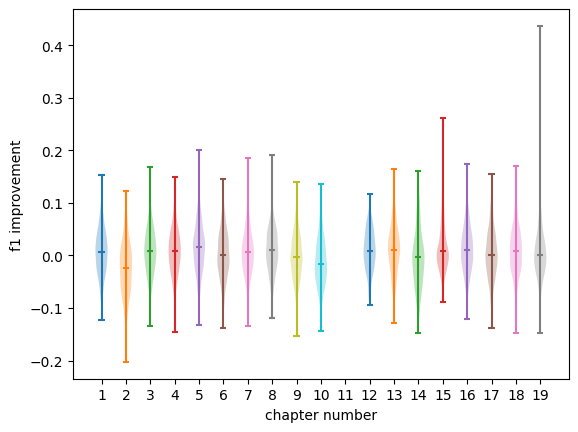

In [29]:
chapter_f1s = get_stats_chapter('f1', diff=True)

fig, ax = plt.subplots()
positions = range(1, len(chapter_f1s.keys())+2)

for chapter_num, f1s in chapter_f1s.items():
    ax.violinplot(f1s, positions=[positions[chapter_num-1]], showmedians=True)

plt.xticks(ticks=positions)
plt.ylabel('f1 improvement')
plt.xlabel('chapter number')
plt.show()


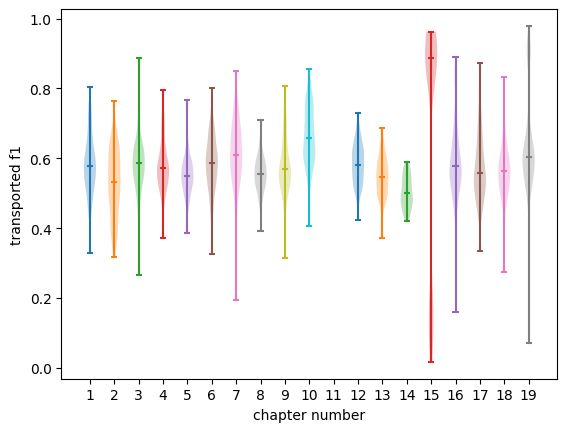

In [33]:
chapter_f1s = get_stats_chapter('f1', diff=False)

fig, ax = plt.subplots()
positions = range(1, len(chapter_f1s.keys())+2)

for chapter_num, f1s in chapter_f1s.items():
    ax.violinplot(f1s, positions=[positions[chapter_num-1]], showmedians=True)

plt.xticks(ticks=positions)
plt.ylabel('transported f1')
plt.xlabel('chapter number')
plt.show()


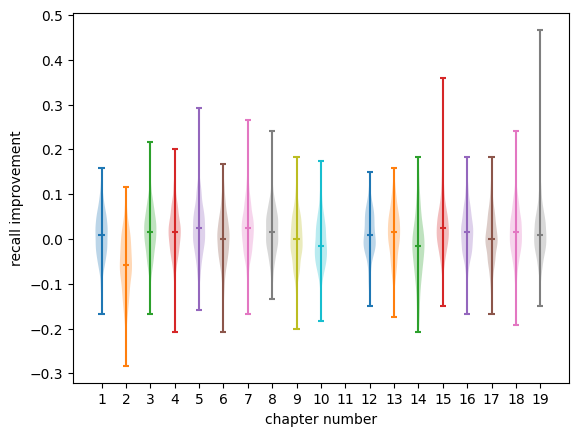

In [34]:
chapter_f1s = get_stats_chapter('recall', diff=True)

fig, ax = plt.subplots()
positions = range(1, len(chapter_f1s.keys())+2)

for chapter_num, f1s in chapter_f1s.items():
    ax.violinplot(f1s, positions=[positions[chapter_num-1]], showmedians=True)

plt.xticks(ticks=positions)
plt.ylabel('recall improvement')
plt.xlabel('chapter number')
plt.show()


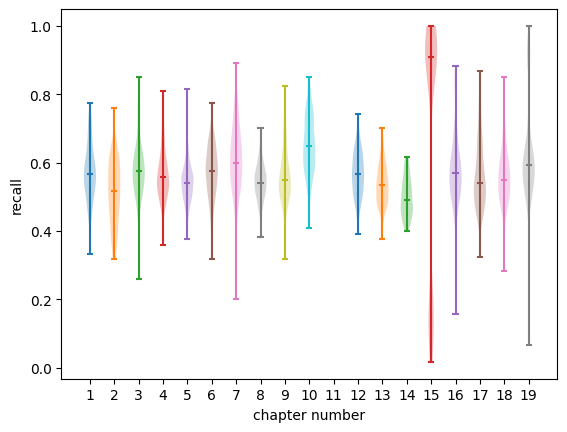

In [35]:
chapter_f1s = get_stats_chapter('recall', diff=False)

fig, ax = plt.subplots()
positions = range(1, len(chapter_f1s.keys())+2)

for chapter_num, f1s in chapter_f1s.items():
    ax.violinplot(f1s, positions=[positions[chapter_num-1]], showmedians=True)

plt.xticks(ticks=positions)
plt.ylabel('recall')
plt.xlabel('chapter number')
plt.show()


ICD codes dense at lower rank: 4 (Diseases of the Blood and Blood-forming Organs), 8 (Diseases of the Respiratory System), 15 (Certain Conditions originating in the Perinatal Period)

ICD codes dense at higher rank: 2 (Neoplasms), 9 (Diseases of the Digestive System), 17 (Injury and Poisoning), 18 (Supplementary Classification of External Causes of Injury and Poisoning)

Question: What does the transferability score suggest? Is transferability score low a good thing?

- the classification task: predicts the presence of one code given other codes, the dependence between one code and the rest modelled by the logistic regression

- representations between two domains with the target code being the response can be more easily transfered/aligned

- application: predicting missing data for the test set.

In [2]:
def ratios_for_metrics(score_dir, label_code, eval_metric, trans_metrics):
    """ 
    Compute ratios for the evaluation metrics (eval_metric)

    :param str label_code: label code as the response to the classification task
    :param str eval_metric: evaluation metric, precision, recall or f1, \
        since this is a classification task.
    :param str trans_metric: transporting metric, OT, TCA or MMD
    """

    metric_improve_ratios = []
    for trans_metric in trans_metrics:
        score_path = os.path.join(score_dir, f"exp3_{label_code}_{trans_metric}_score.csv")
        score_df = pd.read_csv(score_path, header=0, index_col=0)

        # compute improvements in terms of ratio
        metric_improve_ratios.append(compute_metric_ratio(score_df, eval_metric))

    return metric_improve_ratios


In [48]:
trans_metrics = ['OT', 'TCA', 'MMD']
score_dir = "/home/wanxinli/OTTEHR/outputs/mimic/"
target_chapter_num = 6 # Certain Conditions originating in the Perinatal Period

for file in os.listdir(score_dir):
    if file.endswith("OT_score.csv") and 'exp3_' in file:
        label_code = file.split('_')[1]

        chapter_num, _ = decide_ICD_chapter(label_code)
        if chapter_num == target_chapter_num: 
            improve_ratios = ratios_for_metrics(score_dir, label_code, 'f1', trans_metrics)

            # Pandas dataframe
            data = pd.DataFrame({
                trans_metrics[0]: improve_ratios[0],
                trans_metrics[1]: improve_ratios[1],
                trans_metrics[2]: improve_ratios[2]
            })

            # Plot the dataframe
            plt.violinplot(data)
            plt.boxplot(data, flierprops={'markersize': 3})
            plt.xticks([1, 2, 3], labels=trans_metrics)
            plt.ylabel(f"f1 ratio improvement for {label_code}")
            plt.show()



NameError: name 'ratios_for_metrics' is not defined

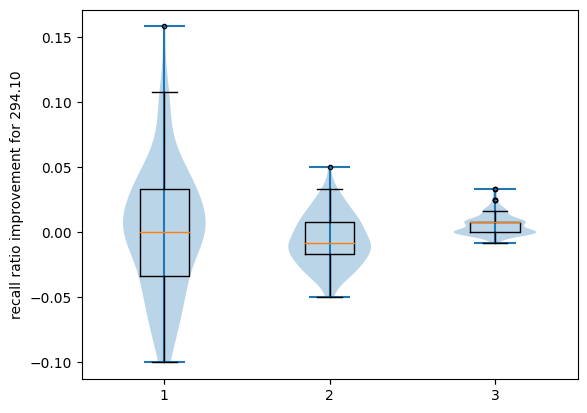

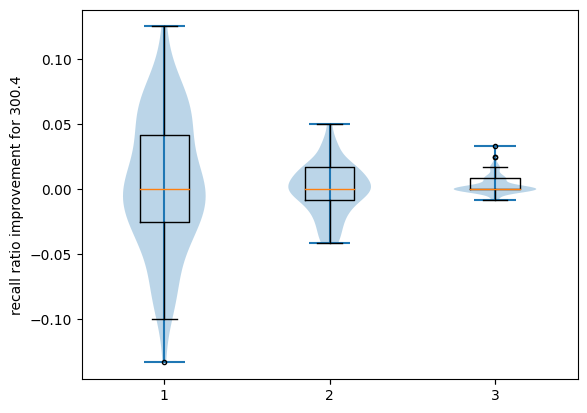

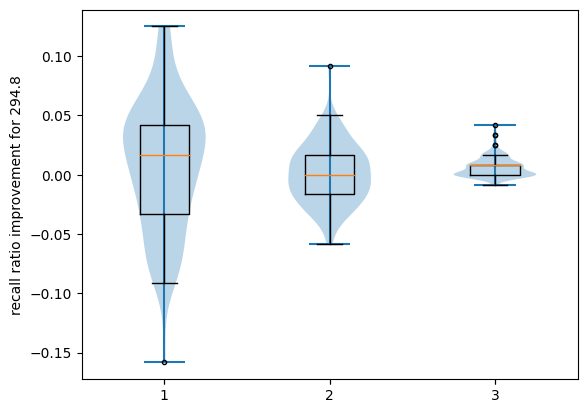

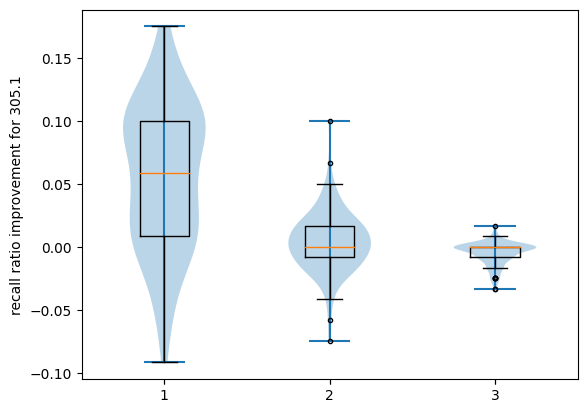

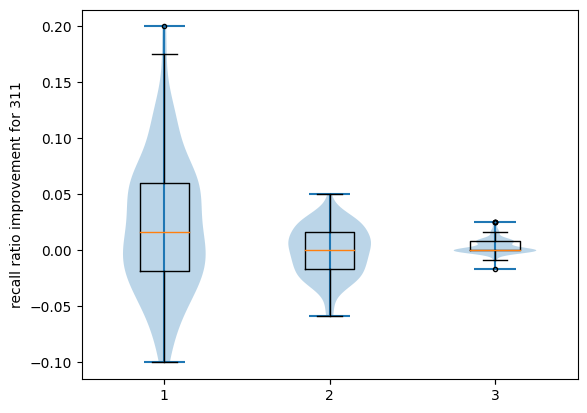

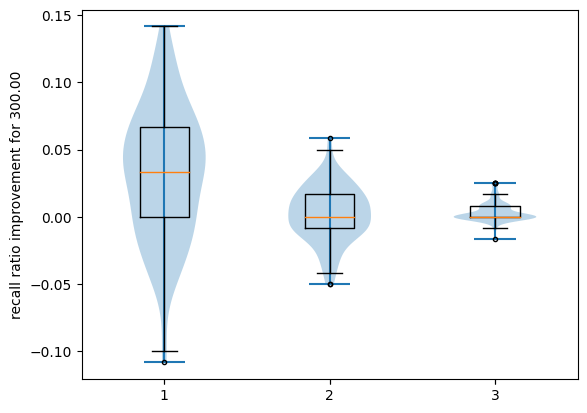

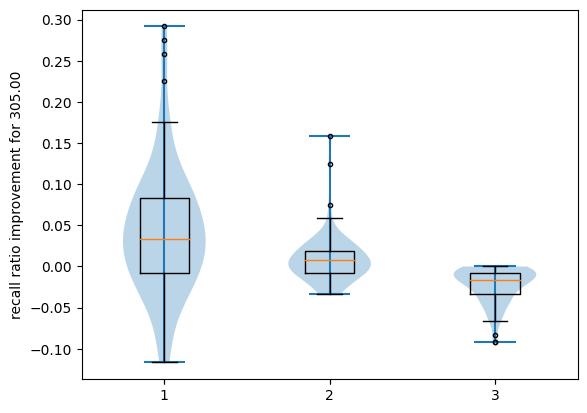

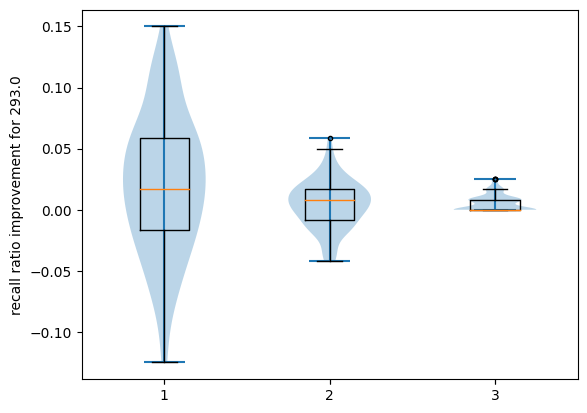

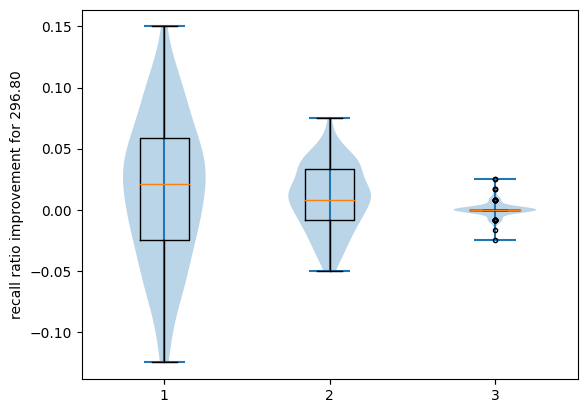

In [4]:
for file in os.listdir(score_dir):
    if file.endswith("OT_score.csv") and 'exp3_' in file:
        label_code = file.split('_')[1]

        chapter_num, _ = decide_ICD_chapter(label_code)
        if chapter_num == target_chapter_num: 
            improve_ratios = ratios_for_metrics(score_dir, label_code, 'recall', trans_metrics)

            # Pandas dataframe
            data = pd.DataFrame({
                trans_metrics[0]: improve_ratios[0],
                trans_metrics[1]: improve_ratios[1],
                trans_metrics[2]: improve_ratios[2]
            })

            # Plot the dataframe
            plt.violinplot(data)
            plt.xticks([1, 2, 3], labels=trans_metrics)
            plt.boxplot(data, flierprops={'markersize': 3})
            plt.ylabel(f"recall ratio improvement for {label_code}")
            plt.show()

